In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np
import keras
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import io
import numpy as np

## Load emulator

In [8]:
path_DNN_NFailed_PFTs = "/home/adam/cloud/gdrive/FATES/Earth-System-Model-Tools/ml_emulators/saved_models/DNN_NFailed_103123_v1.h5"
DNN_NFailed_PFTs = keras.models.load_model(path_DNN_NFailed_PFTs)

path_to_ensemble_data ='/home/adam/cloud/gdrive/FATES/Earth-System-Model-Tools/ml_emulators/all_member_output_101223.csv'

## Check that saved model is working

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Columns: 117 entries, Unnamed: 0 to case_tag
dtypes: float64(113), int64(4)
memory usage: 2.7 MB


['BA', 'AGB', 'TreeStemD', 'ResproutD_oak', 'ResproutD_shrub', 'ShannonE', 'NPP', 'FailedPFTs', 'Pct_shrub_cover_canopy', 'Pct_shrub_cover', 'Combustible_fuel', 'BA_pine', 'BA_cedar', 'BA_fir', 'BA_shrub', 'BA_oak', 'inst', 'fates_recruit_seed_alloc_mature_1', 'fates_recruit_seed_alloc_mature_2', 'fates_recruit_seed_alloc_mature_3', 'fates_recruit_seed_alloc_mature_4', 'fates_recruit_seed_alloc_mature_5', 'fates_recruit_seed_dbh_repro_threshold_1', 'fates_recruit_seed_dbh_repro_threshold_2', 'fates_recruit_seed_dbh_repro_threshold_3', 'fates_recruit_seed_dbh_repro_threshold_5', 'fates_fire_alpha_SH_1', 'fates_fire_alpha_SH_2', 'fates_fire_alpha_SH_3', 'fates_fire_alpha_SH_4', 'fates_fire_alpha_SH_5', 'fates_fire_bark_scaler_1', 'fates_fire_bark_scaler_2', 'fates_fire_bark_scaler_3', 'fates_fire_bark_scaler_4', 'fate

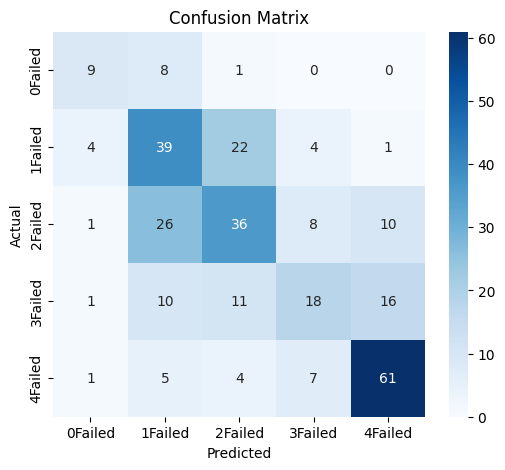

              precision    recall  f1-score   support

     0Failed       0.56      0.50      0.53        18
     1Failed       0.44      0.56      0.49        70
     2Failed       0.49      0.44      0.46        81
     3Failed       0.49      0.32      0.39        56
     4Failed       0.69      0.78      0.73        78

    accuracy                           0.54       303
   macro avg       0.53      0.52      0.52       303
weighted avg       0.53      0.54      0.53       303



In [14]:
raw_df = pd.read_csv(path_to_ensemble_data)
raw_df.info()
print("\n")

# Drop first column
raw_df.drop(columns=raw_df.columns[0], axis=1, inplace=True)
print(list(raw_df.columns))

df = raw_df.copy()
df.fillna(0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.1, random_state = 42)

# Split the data into training and test sets, maintaining an equal proportion of veg and non-veg labels in each.
for train_index, test_index in split.split(df, df['FailedPFTs']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

X_cols = train_set.columns[train_set.columns.str.contains('fates')]
train_X = train_set[X_cols]
test_X = test_set[X_cols]

#Create vars to be predicted
train_y_failedPFTs = train_set["FailedPFTs"].copy()

test_y_failedPFTs = test_set["FailedPFTs"].copy()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# This is for if I need to define a custom data transformation function
from sklearn.base import BaseEstimator, TransformerMixin

# Data transformation pipeline
transformation_pipeline = Pipeline([
        ('std_scaler', StandardScaler()), # Scale the data by substracting mean and dividing by sigma
    ])

# Apply transformation pipeline to training data
X = transformation_pipeline.fit_transform(train_X)

# Apply to test data
X_test = transformation_pipeline.fit_transform(test_X)


from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
loss, accuracy = DNN_NFailed_PFTs.evaluate(X_test, test_y_failedPFTs)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

probabilities = DNN_NFailed_PFTs.predict(X_test)
y_pred = np.argmax(probabilities, axis=1)
print(y_pred)

target_names = [str(i) + "Failed" for i in range(5)]

# Compute the confusion matrix
cm = confusion_matrix(test_y_failedPFTs, y_pred)

# Display the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Optionally, display the classification report for more detailed metrics
print(classification_report(test_y_failedPFTs, y_pred, target_names= target_names))